In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Drive Mount

In [44]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [45]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Configuration




In [46]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Setup output directory
output_dir = "/content/output"
os.makedirs(output_dir, exist_ok=True)

Using device: cuda


# Data preparation

In [47]:
# Config
model_name = "dmis-lab/biobert-base-cased-v1.1"
num_labels = 2
max_length = 512
batch_size = 4
learning_rate = 2e-5
num_epochs = 10
weight_decay = 0.01
adam_epsilon = 1e-8
max_grad_norm = 1.0
warmup_ratio = 0.1

# Load data paths (adapt these in Colab, e.g. upload or mount drive)
train_path = "/content/drive/MyDrive/NLP/train.json"
dev_path = "/content/drive/MyDrive/NLP/dev.json"
test_path = "/content/drive/MyDrive/NLP/test.json"

# Load JSON files
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # JSON might be dict with IDs as keys or list of dicts - convert to list of dicts
    if isinstance(data, dict):
        data = list(data.values())
    return data

train_data = load_json(train_path)
dev_data = load_json(dev_path)
test_data = load_json(test_path)

print(f"Train samples: {len(train_data)}")
print(f"Dev samples: {len(dev_data)}")
print(f"Test samples: {len(test_data)}")



Train samples: 1700
Dev samples: 200
Test samples: 5500


# EDA


=== TRAIN DATASET ANALYSIS ===
Total samples: 1700
Label distribution:
  Contradiction: 850 (50.00%)
  Entailment: 850 (50.00%)
Text length (words): min=6, max=65, mean=19.67, median=18.0


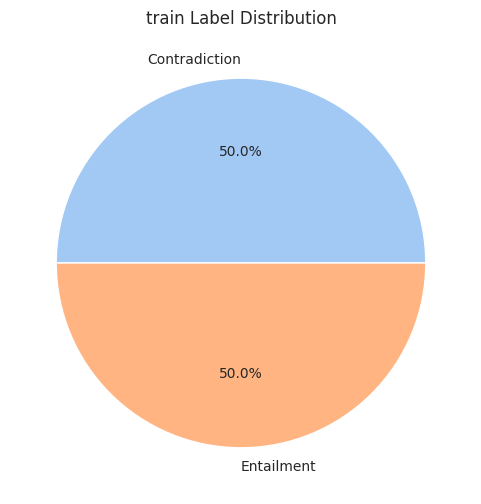

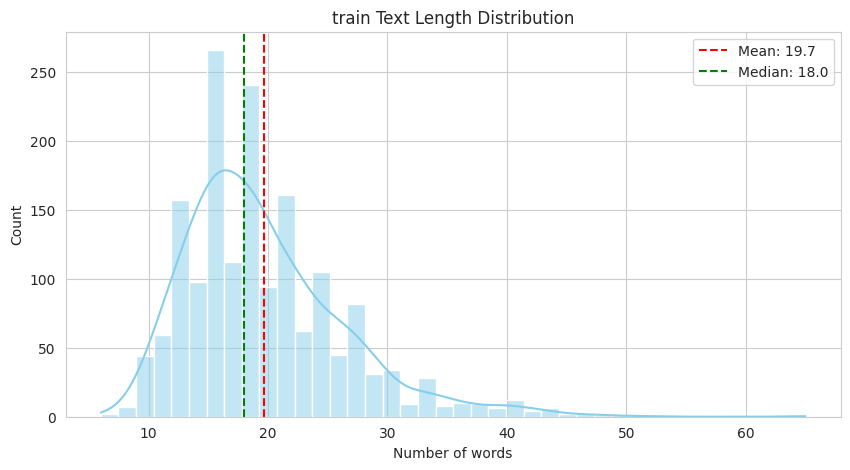


=== DEV DATASET ANALYSIS ===
Total samples: 200
Label distribution:
  Contradiction: 100 (50.00%)
  Entailment: 100 (50.00%)
Text length (words): min=9, max=39, mean=18.68, median=17.0


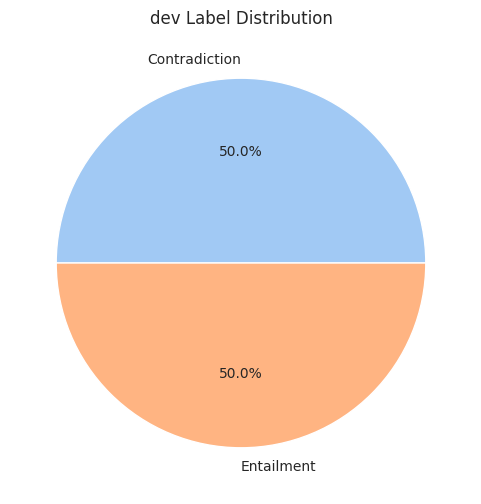

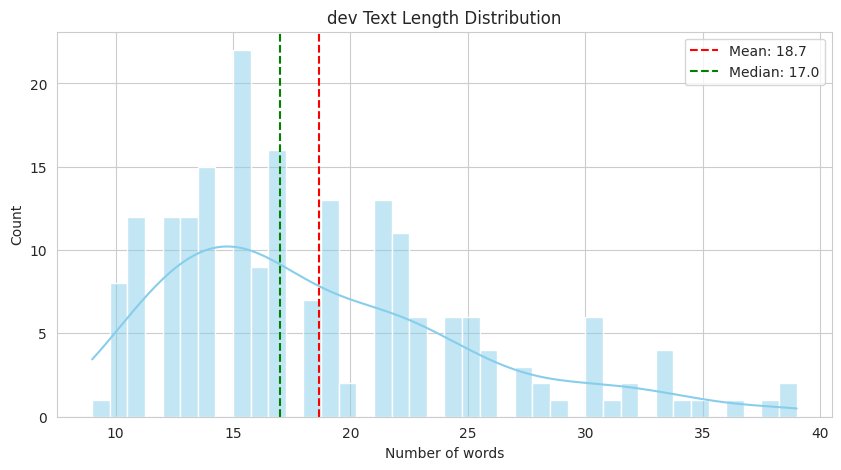


=== TEST DATASET ANALYSIS ===
Total samples: 5500
Label distribution:
  Unknown: 5500 (100.00%)
Text length (words): min=8, max=75, mean=27.26, median=25.0


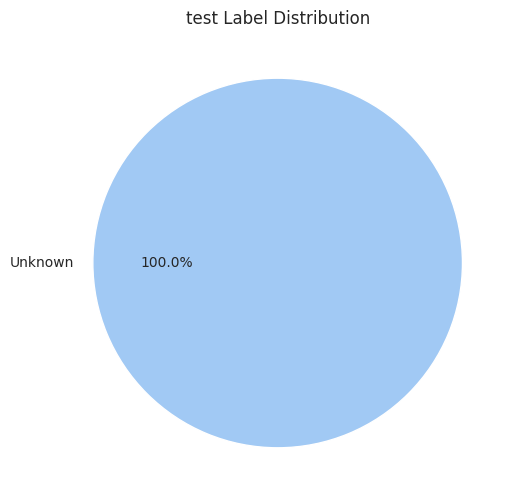

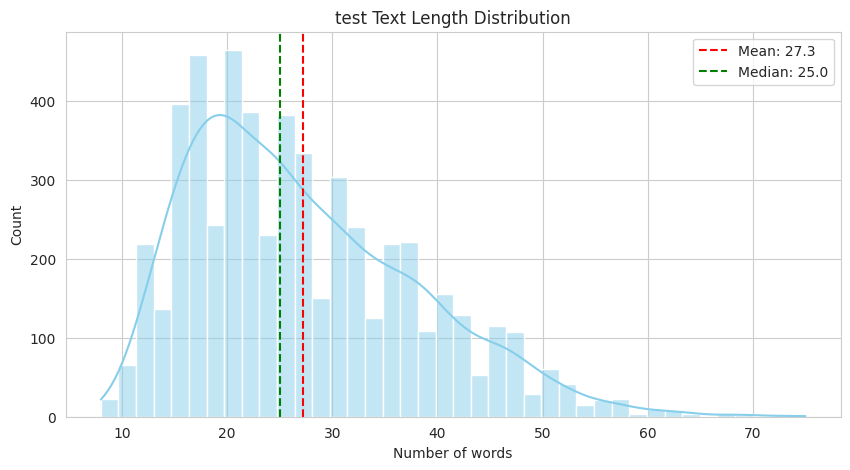

In [48]:
# EDA: Label distribution and text length stats + plots

def print_and_plot_eda(data, name):
    print(f"\n=== {name.upper()} DATASET ANALYSIS ===")
    label_counts = defaultdict(int)
    text_lengths = []
    for d in data:
        lbl = d.get('Label', 'Unknown')
        label_counts[lbl] += 1
        statement = str(d.get('Statement', ''))
        text_lengths.append(len(statement.split()))
    total = len(data)

    print(f"Total samples: {total}")
    print("Label distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} ({count/total*100:.2f}%)")
    print(f"Text length (words): min={min(text_lengths)}, max={max(text_lengths)}, mean={np.mean(text_lengths):.2f}, median={np.median(text_lengths)}")

    # Pie chart for label distribution
    plt.figure(figsize=(6,6))
    plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    plt.title(f"{name} Label Distribution")
    plt.savefig(os.path.join(output_dir, f"{name}_label_dist.png"))
    plt.show()

    # Histogram for text length
    plt.figure(figsize=(10,5))
    sns.histplot(text_lengths, bins=40, kde=True, color='skyblue')
    plt.axvline(np.mean(text_lengths), color='r', linestyle='--', label=f"Mean: {np.mean(text_lengths):.1f}")
    plt.axvline(np.median(text_lengths), color='g', linestyle='--', label=f"Median: {np.median(text_lengths)}")
    plt.title(f"{name} Text Length Distribution")
    plt.xlabel("Number of words")
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"{name}_text_length_dist.png"))
    plt.show()

print_and_plot_eda(train_data, "train")
print_and_plot_eda(dev_data, "dev")
print_and_plot_eda(test_data, "test")



# Data loading and Tokenization

In [49]:
# Prepare tokenizer and dataset class

tokenizer = AutoTokenizer.from_pretrained(model_name)

class ClinicalTrialsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=max_length, is_training=True):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_training = is_training
        self.label_map = {"Entailment": 0, "Contradiction": 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        statement = str(item.get('Statement', ''))
        trial_id = item.get('CTR', item.get('Primary_id', f"id_{idx}"))
        text = f"Statement: {statement} [SEP] Clinical Trial: {trial_id}"

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )

        result = {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "text": text,
            "trial_id": trial_id,
            "statement": statement
        }

        if self.is_training or 'Label' in item:
            label = item.get('Label', '')
            label_id = self.label_map.get(label, -1)
            result['labels'] = torch.tensor(label_id, dtype=torch.long)
            result['label_str'] = label

        return result

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    out = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "text": [item['text'] for item in batch],
        "trial_id": [item['trial_id'] for item in batch],
        "statement": [item['statement'] for item in batch]
    }
    if 'labels' in batch[0]:
        out['labels'] = torch.stack([item['labels'] for item in batch])
    return out

train_dataset = ClinicalTrialsDataset(train_data, tokenizer, is_training=True)
dev_dataset = ClinicalTrialsDataset(dev_data, tokenizer, is_training=True)
test_dataset = ClinicalTrialsDataset(test_data, tokenizer, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Training Model

In [50]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

# Optimizer and scheduler setup
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon, weight_decay=weight_decay)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(warmup_ratio * total_steps), num_training_steps=total_steps)

best_val_accuracy = 0.0
best_model_path = os.path.join(output_dir, "best_model.pt")

print("\nStarting training...\n")
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate on dev set
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(dev_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Val F1 Score: {val_f1:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with accuracy {val_accuracy:.4f}")

print("\nTraining complete!")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...



Training Epoch 1:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 1 Results:
  Train Loss: 0.7023
  Val Loss: 0.7105
  Val Accuracy: 0.5000
  Val F1 Score: 0.3333
✅ Best model saved at epoch 1 with accuracy 0.5000


Training Epoch 2:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 2 Results:
  Train Loss: 0.7032
  Val Loss: 0.6734
  Val Accuracy: 0.5950
  Val F1 Score: 0.5921
✅ Best model saved at epoch 2 with accuracy 0.5950


Training Epoch 3:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 3 Results:
  Train Loss: 0.6946
  Val Loss: 0.6624
  Val Accuracy: 0.6100
  Val F1 Score: 0.6061
✅ Best model saved at epoch 3 with accuracy 0.6100


Training Epoch 4:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 4 Results:
  Train Loss: 0.6767
  Val Loss: 0.6329
  Val Accuracy: 0.6350
  Val F1 Score: 0.6350
✅ Best model saved at epoch 4 with accuracy 0.6350


Training Epoch 5:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 5 Results:
  Train Loss: 0.6435
  Val Loss: 0.6726
  Val Accuracy: 0.6600
  Val F1 Score: 0.6443
✅ Best model saved at epoch 5 with accuracy 0.6600


Training Epoch 6:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 6 Results:
  Train Loss: 0.5701
  Val Loss: 0.7363
  Val Accuracy: 0.6450
  Val F1 Score: 0.6410


Training Epoch 7:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 7 Results:
  Train Loss: 0.4697
  Val Loss: 0.9791
  Val Accuracy: 0.6450
  Val F1 Score: 0.6310


Training Epoch 8:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 8 Results:
  Train Loss: 0.3969
  Val Loss: 1.3805
  Val Accuracy: 0.6150
  Val F1 Score: 0.6122


Training Epoch 9:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 9 Results:
  Train Loss: 0.3198
  Val Loss: 1.6973
  Val Accuracy: 0.6150
  Val F1 Score: 0.6128


Training Epoch 10:   0%|          | 0/425 [00:00<?, ?it/s]


Epoch 10 Results:
  Train Loss: 0.2594
  Val Loss: 1.7895
  Val Accuracy: 0.6250
  Val F1 Score: 0.6208

Training complete!


# Evaluation

In [56]:
# Load best model for final evaluation
print("\nLoading best model for evaluation on dev set...")
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

# Final detailed dev evaluation
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["Entailment", "Contradiction"], digits=4))


Loading best model for evaluation on dev set...

Validation Classification Report:
               precision    recall  f1-score   support

   Entailment     0.6127    0.8700    0.7190       100
Contradiction     0.7759    0.4500    0.5696       100

     accuracy                         0.6600       200
    macro avg     0.6943    0.6600    0.6443       200
 weighted avg     0.6943    0.6600    0.6443       200



# Confusion Matrix

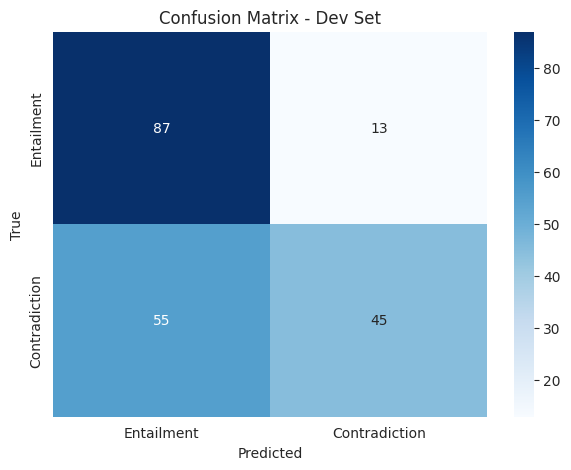

In [57]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Entailment", "Contradiction"], yticklabels=["Entailment", "Contradiction"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Dev Set")
plt.savefig(os.path.join(output_dir, "confusion_matrix_dev.png"))
plt.show()

# Inference on test set

In [58]:
# Inference on test set and save predictions CSV
print("\nRunning inference on test set...")
preds = []
probs = []
trial_ids = []
texts = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test inference"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        softmax = torch.nn.functional.softmax(logits, dim=1)

        preds.extend(torch.argmax(softmax, dim=1).cpu().numpy())
        probs.extend(softmax.cpu().numpy())
        trial_ids.extend(batch["trial_id"])
        texts.extend(batch["text"])

results_df = pd.DataFrame({
    "trial_id": trial_ids,
    "text": texts,
    "predicted_label": ["Entailment" if p == 0 else "Contradiction" for p in preds],
    "entailment_prob": [p[0] for p in probs],
    "contradiction_prob": [p[1] for p in probs],
})

csv_path = os.path.join(output_dir, "test_predictions.csv")
results_df.to_csv(csv_path, index=False)
print(f"✅ Test predictions saved to {csv_path}")

# Done!
print("\nAll done. Check the output directory for saved models, plots, and predictions.")


Running inference on test set...


Test inference:   0%|          | 0/1375 [00:00<?, ?it/s]

✅ Test predictions saved to /content/output/test_predictions.csv

All done. Check the output directory for saved models, plots, and predictions.


# Download results

In [59]:
import shutil
shutil.make_archive('/content/output', 'zip', '/content/output')

from google.colab import files
files.download('/content/output.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>